# Face Recognition: Look How Far We've Come  .. Even More (Part 3A)

In this notebook, I continue the computer vision ("CV") solution from Part 1's canonical Eigenface approach and continue exploring Deep Learning ("DL"), trying to better the results of Section 3, the first incarnation of a DL solution to this problem.  

# 3A. The Deep Learning Approach - Redux

In [1]:
# Import the libraries needed for the deep learning approach to facial recognition
from keras.engine import Model
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
# Now we need TensorFlow itself, as well same control (see Section 3A.2 below) of its memory allocation
import tensorflow as tf
from keras.backend import clear_session
from keras.backend.tensorflow_backend import set_session
# Now we need the VGG16 model optimized for face recognition, VGGFace
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
# Re-import libraries from prior sections in the event that you are restarting here
import numpy as np
import math
import cv2
import os
from os.path import expanduser
import pickle as pkl
import string
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from copy import copy, deepcopy
from haar_helper_functions import store_ground_truth  # This helper function from Solution 2 is recycled here
# The below imports are from dl_3A_helpers.py, a set of helper functions for this notebook
from dl_3A_helpers import create_data_dirs, create_data_in_sets, fetch_data_sets, randomize_data_set, randomize_set
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# Restore from file anything saved from previous sections, at least some of which will be needed for this exercise
with open('pic_dir.pickle', 'rb') as picture_path:
    image_3D_dir = pkl.load(picture_path)
    home_dir = pkl.load(picture_path)
    lfw_img_dir = pkl.load(picture_path)
    project_folder = pkl.load(picture_path)
    project_path = pkl.load(picture_path)
with open('images_3D_RGB_top7.pickle', 'rb') as picture_pickle:
    images_3D_RGB = pkl.load(picture_pickle)
with open('df_ground_truth.pickle', 'rb') as ground_truth_pickle:
    df_ground_truth = pkl.load(ground_truth_pickle)
with open('testing_data.pickle', 'rb') as testing_data_pickle:
    train_X = pkl.load(testing_data_pickle) # This isn't needed, but we need the later objects of this .pkl file
    test_X = pkl.load(testing_data_pickle) # This isn't needed, but we need the later objects of this .pkl file
    train_y = pkl.load(testing_data_pickle) # This isn't needed, but we need the later objects of this .pkl file
    test_y = pkl.load(testing_data_pickle) # This isn't needed, but we need the later objects of this .pkl file
    test_y_int = pkl.load(testing_data_pickle) # This isn't needed, but we need the later objects of this .pkl file
    test_y_names = pkl.load(testing_data_pickle) # This isn't needed, but we need the later objects of this .pkl file
    n_classes = pkl.load(testing_data_pickle)
    name_image_counts = pkl.load(testing_data_pickle)
    person_names = pkl.load(testing_data_pickle)
    index_name_dict = pkl.load(testing_data_pickle)
    name_index_dict = pkl.load(testing_data_pickle)
with open('vgg_f_params.pickle', 'rb') as vgg_f_par:
    BGR_means = pkl.load(vgg_f_par)
    img_height_req = pkl.load(vgg_f_par)
    img_width_req = pkl.load(vgg_f_par)
    img_channels_req = pkl.load(vgg_f_par)

So, here's an idea.  The photos themselves were of excellent quality, with little obscuring of the desired face, all shots straight-on (e.g., not profiles), etc.   We did, however, find benefit in some image pre-processing (e.g., denoising) in Solution 2, and we are fairly certain that the dataset imbalance is causing, at least in part, classification confusion.  Before reasonable results were obtained in Solution 3, e.g., many earlier models simply classified every image as George_W_Bush - not suprising, given that > 40% of the patterns the algorithm was trying categorize into 7 classes are photos of him.  

Let's try something - spruce up the photos a bit, balance the dataset, and see if we can improve upon Solution 3's results.  Ordinarily, we would seek to add photos, but let's see what happens when we delete photos (i.e., under-sampling), in this case keeping only the 1st 70 photos of each of the 7 persons of interest.   We have no reason to believe that the order/placement of any picture in a person's directory is of any import, and, in fact, the numerical suffixes of those photo file names belie such a supposition.   Therefore, we believe, we can simply read in the 7 classes/folders of images and for each put the first few in the training, the next few in the validation, and the final few in the testing sets/folders.    

In [3]:
# Define common/shared directories/file folder names used by below functions
dl_data_subdir = 'data' # deep learning data directory
train_data_dir = 'train'
validation_data_dir = 'validation'
test_data_dir = 'test'
data_subdirs = [train_data_dir, validation_data_dir, test_data_dir]
data_dir = expanduser(os.path.join(image_3D_dir, dl_data_subdir))

# Intialize lists as empty to capture the balanced image set split between train, val, and test
train_X_3A = [] # balanced subset of train images
train_y_3A = [] # labels corresponding to above balanced subset
val_X_3A = [] # balanced subset of validation images
val_y_3A = [] # labels corresponding to above balanced subset
test_X_3A = [] # balanced subset of test images
test_y_3A = [] # labels corresponding to above balanced subset

# Set the size of each classes total images (train, val, & test altogether)
class_sample_cnt = 70

In [4]:
# Create typical Computer Vision sub-database, populate it with balanced imgs, & capture and persist results
if not os.path.exists(os.path.join(os.path.expanduser(os.getcwd()), data_dir)):
    # Create (i) the data dir, (ii) its train, val, & test sub-dirs, & (iii) the 7 name sub-dirs in each sub-dir
    create_data_dirs(image_3D_dir, dl_data_subdir, data_subdirs, person_names, home_dir, project_folder)
    # Copy the first 70 files from each of the 7 person-of-interest folders to the 'data' sub-dir just created
    train_sample_count, val_sample_count, test_sample_count = \
        create_data_in_sets(image_3D_dir, data_dir, data_subdirs, person_names, \
        class_sample_cnt, home_dir, project_folder)
    sample_counts = [train_sample_count, val_sample_count, test_sample_count]
    # Fetch the datasets just created (all images now in RGB and denoised)
    train_X_3A, train_y_3A, val_X_3A, val_y_3A, test_X_3A, test_y_3A = \
        fetch_data_sets(data_dir, data_subdirs, person_names, sample_counts, n_classes)
    # Save these six sets for later use
    with open('pic_trunc.pickle', 'wb') as picture_truncated:
        pkl.dump(train_X_3A, picture_truncated, protocol=pkl.HIGHEST_PROTOCOL)
        pkl.dump(train_y_3A, picture_truncated, protocol=pkl.HIGHEST_PROTOCOL)
        pkl.dump(val_X_3A, picture_truncated, protocol=pkl.HIGHEST_PROTOCOL)
        pkl.dump(val_y_3A, picture_truncated, protocol=pkl.HIGHEST_PROTOCOL)
        pkl.dump(test_X_3A, picture_truncated, protocol=pkl.HIGHEST_PROTOCOL)
        pkl.dump(test_y_3A, picture_truncated, protocol=pkl.HIGHEST_PROTOCOL)
    with open('pic_sample_counts.pickle', 'wb') as count_numbers:
        pkl.dump(train_sample_count, count_numbers, protocol=pkl.HIGHEST_PROTOCOL)
        pkl.dump(val_sample_count, count_numbers, protocol=pkl.HIGHEST_PROTOCOL)
        pkl.dump(test_sample_count, count_numbers, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open('pic_trunc.pickle', 'rb') as picture_truncated:
        train_X_3A = pkl.load(picture_truncated)
        train_y_3A = pkl.load(picture_truncated)
        val_X_3A = pkl.load(picture_truncated)
        val_y_3A = pkl.load(picture_truncated)        
        test_X_3A = pkl.load(picture_truncated)
        test_y_3A = pkl.load(picture_truncated)
    with open('pic_sample_counts.pickle', 'rb') as count_numbers:
        train_sample_count = pkl.load(count_numbers)
        val_sample_count = pkl.load(count_numbers)
        test_sample_count = pkl.load(count_numbers)

In [5]:
# Copy off the ground truth data for the train, val, and test sets
df_train_ground_truth = store_ground_truth(person_names, [train_sample_count]*n_classes)
df_val_ground_truth = store_ground_truth(person_names, [val_sample_count]*n_classes)
df_test_ground_truth = store_ground_truth(person_names, [test_sample_count]*n_classes)

In [6]:
# Now let's capture (via img indx in each sub-set) randomizing the train, val, & test imgs, matched with their labels
df_train_gt_rnd = randomize_data_set(df_train_ground_truth)
df_val_gt_rnd = randomize_data_set(df_val_ground_truth)
df_test_gt_rnd = randomize_data_set(df_test_ground_truth)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

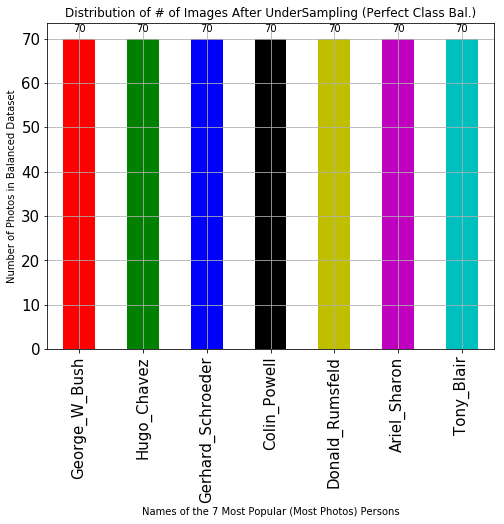

In [7]:
# Plot the now-balanced dataset
plt.clf();
column_names = person_names;
my_colors = 'rgbkymc';
# Based upon http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html
df_bal = pd.DataFrame(list(np.repeat(class_sample_cnt, n_classes)), [x for x in column_names]);
plt.figure();
ax = df_bal.plot(kind='bar', figsize=(8,6), \
              title='Distribution of # of Images After UnderSampling (Perfect Class Bal.)', \
              grid=True, stacked=True, color=my_colors, sort_columns=False, legend=False, fontsize=15);
ax.set_xlabel("Names of the 7 Most Popular (Most Photos) Persons");
ax.set_ylabel("Number of Photos in Balanced Dataset");
# From https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=0).astype(int), (p.get_x()+p.get_width()/2.0, 
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points');
plt.savefig('top7_undersampling.png');

# 3A.1 Preprocess the data and One Hot Encode ("OHE") the labels

In [8]:
# Now One Hote Encode ("OHE") the string labels to Bernoulli vectors
# Now let's actually create the randomized sets with their labels
train_X, train_y_int, train_y_names, train_y_vectors = randomize_set(train_X_3A,df_train_gt_rnd,person_names,n_classes)
val_X, val_y_int, val_y_names, val_y_vectors = randomize_set(val_X_3A,df_val_gt_rnd,person_names,n_classes)
test_X, test_y_int, test_y_names, test_y_vectors = randomize_set(test_X_3A,df_test_gt_rnd,person_names,n_classes)


<Figure size 432x288 with 0 Axes>

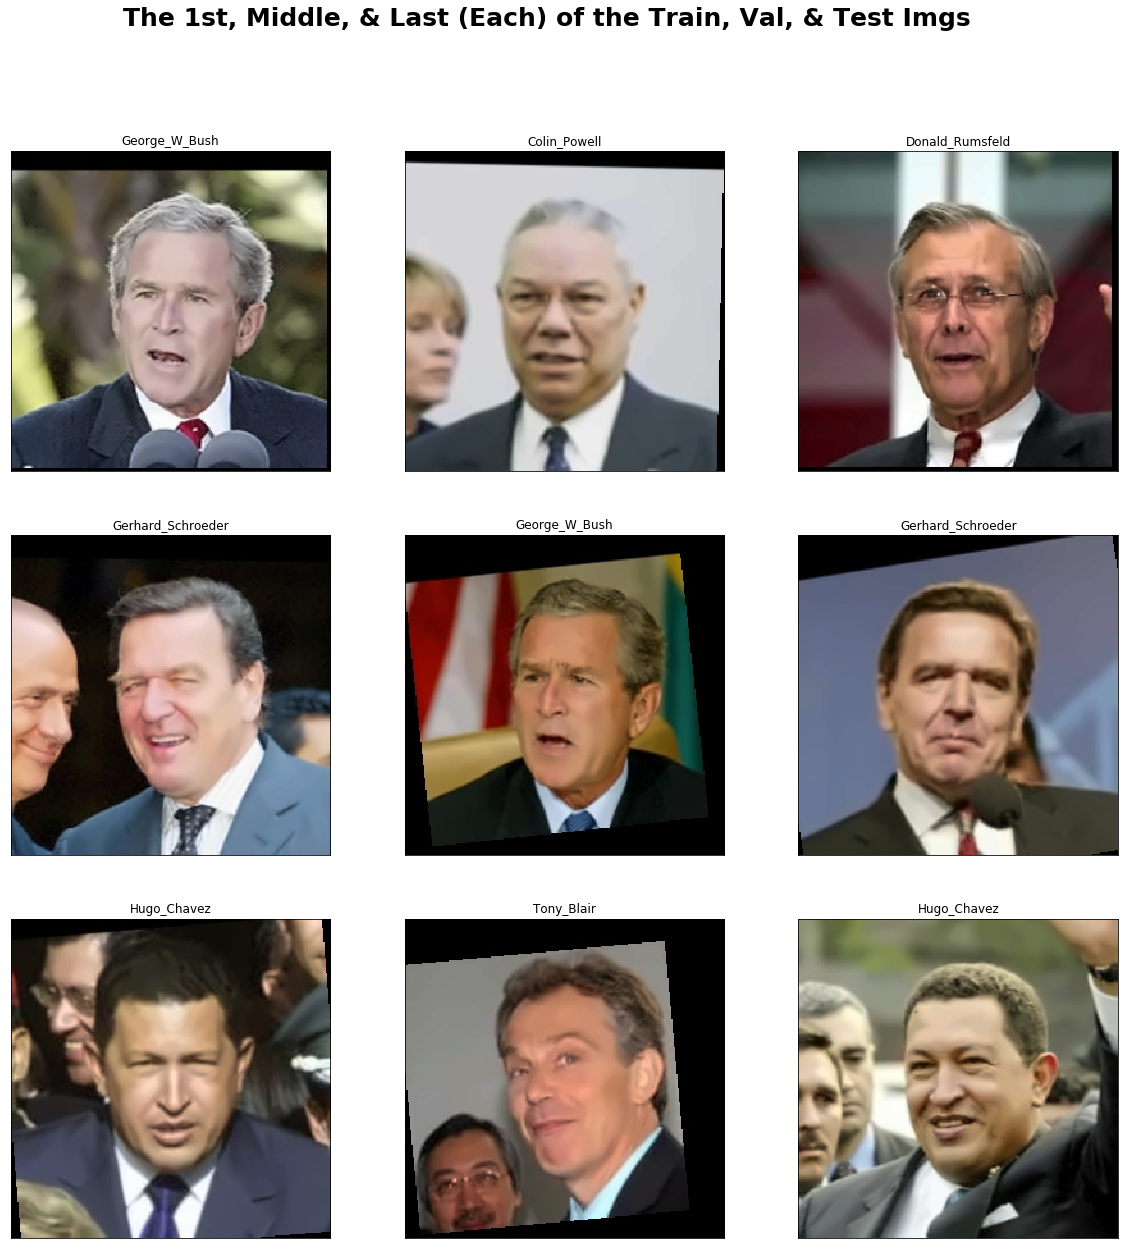

In [9]:
# Let's pick the 1st, midddle, & last each of the train, val, & test images (9 images in total) to view
plt.clf()
sample_cnt = 9
# Get the 3 indices for each of the three lists
train_img_idxs = [0, int(math.floor(len(train_X)/2)), -1]
val_img_idxs = [0, int(math.floor(len(val_X)/2)), -1]
test_img_idxs = [0, int(math.floor(len(test_X)/2)), -1]
# Get the those images for those lists & combine them into 1 list
train_images_samples = [train_X[img_idx] for img_idx in train_img_idxs]
val_images_samples = [val_X[img_idx] for img_idx in val_img_idxs]
test_images_samples = [test_X[img_idx] for img_idx in test_img_idxs]
images_samples = train_images_samples + val_images_samples + test_images_samples
# Get the corresponding labels/names for all 9 images and combine them into 1 list
train_y_samples = [train_y_names[i] for i in train_img_idxs]
val_y_samples = [val_y_names[j] for j in val_img_idxs]
test_y_samples = [test_y_names[k] for k in test_img_idxs]
titles_samples = train_y_samples + val_y_samples + test_y_samples

# Now show the 9 images each with its label/name above it
plt.figure(figsize=(20,20))
plt.suptitle('The 1st, Middle, & Last (Each) of the Train, Val, & Test Imgs', fontsize=25, weight='bold')

for i in range(sample_cnt):
    plt.subplot(331 + (i))
    plt.title(titles_samples[i])
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(images_samples[i])

plt.show()

In [10]:
# Define a function to process the images to computable tensors
def image_to_tensor(img):
    img = cv2.resize(img,(img_height_req, img_width_req)).astype('float32')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = img_to_array(img) # Above converts RGB image back to GBR, the expected color channel chronology of vgg_face
    img = np.absolute(img - BGR_means) # a negative pixel value = its opposite but might confuse models
    img = np.expand_dims(img, axis=0) 
    return np.squeeze(img) # get rid of extraneous axis 0; it will be added with a rank-4 tensor enclosing these

# Reshape and pre-process each train_X, val_X, and test_X.  Then aggregate them into 3 lists

# Copies 1st so as not to change original images
train_X_copy = [deepcopy(img) for img in train_X]
val_X_copy = [deepcopy(img) for img in val_X]
test_X_copy = [deepcopy(img) for img in test_X]
# Normalize as is required for VGGFace
train_X_tf = [image_to_tensor(img) for img in train_X_copy]
val_X_tf = [image_to_tensor(img) for img in val_X_copy]
test_X_tf = [image_to_tensor(img) for img in test_X_copy]

# Reshape the image sets into the required rank_4 tensor shapes (Number_samples, 224,224,3)
train_X_tensors = np.array(train_X_tf)
val_X_tensors = np.array(val_X_tf)
test_X_tensors = np.array(test_X_tf)

# Reshape the label vectors into the required rank_2 tensor shapes (Number_samples, 7)
train_y_tensors = train_y_vectors
val_y_tensors = val_y_vectors
test_y_tensors = test_y_vectors

# Now print summaries of the 3 groups of data and their labels to see if correct
# Adapted from https://github.com/udacity/deep-learning/blob/master/transfer-learning/Transfer_Learning_Solution.ipynb
print("Training shapes (x, y):", train_X_tensors.shape, train_y_tensors.shape)
print("Validation shapes (x, y):", val_X_tensors.shape, val_y_tensors.shape)
print("Testing shapes (x, y):", test_X_tensors.shape, test_y_tensors.shape)

Training shapes (x, y): (392, 224, 224, 3) (392, 7)
Validation shapes (x, y): (49, 224, 224, 3) (49, 7)
Testing shapes (x, y): (49, 224, 224, 3) (49, 7)


# 3A.2 Build a base CNN model atop VGGFace (transfer learning), predict, and evaluate

The default memory allocation sub-algorithm of TensorFlow is to allocate nearly all of available GPU space to the TF graph. This can easily cause Out-of-Memory ("OOM") and related problems, crashing the program. The below script allows for dynamic, rather than initially greedy, processing memory allocation.

In [11]:
# Cause TF to allocate GPU memory dynamically, hopefully obviating out-of_memory ("OOM") & other problems
# From https://github.com/keras-team/keras/issues/4161

clear_session()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [12]:
# Design the initial feature extractor model
vgg_features = VGGFace(include_top=False, input_shape=(img_height_req, img_width_req, img_channels_req), pooling='avg')
last_layer = vgg_features.get_layer('pool5').output
vgg_f_bn = Model(vgg_features.input, last_layer)
vgg_f_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [13]:
# Now obtain the training set logits directly from the bn model
codes_train_bn = vgg_f_bn.predict(train_X_tensors, batch_size=16)
np.save('features_train_bn_3A.npy', codes_train_bn)

In [14]:
# Now obtain the validation set logits directly from the bn model
codes_val_bn = vgg_f_bn.predict(val_X_tensors, batch_size=16)
np.save('features_val_bn_3A.npy', codes_val_bn)

In [15]:
# Top model paramaters
learning_rate = 0.001
epochs = 100 # increasing epsilon (below) slows training, suggesting that more epochs should be needed
beta_one = 0.9
beta_two = 0.999
epsilon = 1e-2 # increasing this deterrant to division by zero adds stability to the system/model
decay_rate = 0.025
amsgrad_bool = False
batch_size = 16

In [16]:
# Instantiate the top model
top_vgg_f_model = Sequential()
top_vgg_f_model.add(Flatten(input_shape=codes_train_bn.shape[1:]))
top_vgg_f_model.add(Dense(512, activation='relu'))
top_vgg_f_model.add(Dropout(0.5))
top_vgg_f_model.add(Dense(256, activation='relu'))
top_vgg_f_model.add(Dropout(0.5))
top_vgg_f_model.add(Dense(n_classes, activation='relu'))
top_vgg_f_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 12,978,695
Trainable params: 12,978,695
Non-trainable params: 0
________________________________________________________________

In [17]:
# Train the top model

top_model_weights_best = 'top_model_weights_best_3A.h5'
datagen_top = ImageDataGenerator(rescale=1.0)
generator_top = datagen_top.flow(val_X_tensors, val_y_tensors, batch_size=batch_size)
train_data = np.load('features_train_bn_3A.npy')
validation_data = np.load('features_val_bn_3A.npy')

# Now ready the top_vgg_f_model for training
adam = Adam(lr=learning_rate, beta_1=beta_one, beta_2=beta_two, epsilon=epsilon, decay=decay_rate, amsgrad=amsgrad_bool)
top_vgg_f_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
top_vgg_f_model.summary()

checkpointer = ModelCheckpoint(filepath=top_model_weights_best, verbose=1, save_best_only=True)
history = top_vgg_f_model.fit(train_data, train_y_tensors, epochs=epochs, batch_size=batch_size,
                        validation_data=(validation_data, val_y_tensors),callbacks=[checkpointer], verbose=1)

top_vgg_f_model.save_weights(top_model_weights_best)

(eval_loss, eval_accuracy) = top_vgg_f_model.evaluate(validation_data, val_y_tensors, batch_size=batch_size, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 12,978,695
Trainable params: 12,978,695
Non-trainable params: 0
________________________________________________________________


Epoch 00030: val_loss improved from 1.60562 to 1.59144, saving model to top_model_weights_best_3A.h5
Epoch 31/100
392/392 [==============================] - 1s 1ms/step - loss: 1.6758 - acc: 0.4184 - val_loss: 1.5760 - val_acc: 0.7551

Epoch 00031: val_loss improved from 1.59144 to 1.57599, saving model to top_model_weights_best_3A.h5
Epoch 32/100
392/392 [==============================] - 1s 1ms/step - loss: 1.5637 - acc: 0.4490 - val_loss: 1.5599 - val_acc: 0.7551

Epoch 00032: val_loss improved from 1.57599 to 1.55988, saving model to top_model_weights_best_3A.h5
Epoch 33/100
392/392 [==============================] - 1s 1ms/step - loss: 1.6646 - acc: 0.4005 - val_loss: 1.5435 - val_acc: 0.8163

Epoch 00033: val_loss improved from 1.55988 to 1.54346, saving model to top_model_weights_best_3A.h5
Epoch 34/100
392/392 [==============================] - 1s 1ms/step - loss: 1.5457 - acc: 0.4694 - val_loss: 1.5259 - val_acc: 0.8163

Epoch 00034: val_loss improved from 1.54346 to 1.52587,

392/392 [==============================] - 0s 1ms/step - loss: 1.1645 - acc: 0.6811 - val_loss: 0.9515 - val_acc: 0.8163

Epoch 00066: val_loss improved from 0.96823 to 0.95148, saving model to top_model_weights_best_3A.h5
Epoch 67/100
392/392 [==============================] - 0s 1ms/step - loss: 1.1113 - acc: 0.6709 - val_loss: 0.9419 - val_acc: 0.8776

Epoch 00067: val_loss improved from 0.95148 to 0.94190, saving model to top_model_weights_best_3A.h5
Epoch 68/100
392/392 [==============================] - 0s 1ms/step - loss: 1.1378 - acc: 0.6709 - val_loss: 0.9260 - val_acc: 0.8776

Epoch 00068: val_loss improved from 0.94190 to 0.92605, saving model to top_model_weights_best_3A.h5
Epoch 69/100
392/392 [==============================] - 0s 1ms/step - loss: 1.0940 - acc: 0.6811 - val_loss: 0.9127 - val_acc: 0.8776

Epoch 00069: val_loss improved from 0.92605 to 0.91266, saving model to top_model_weights_best_3A.h5
Epoch 70/100
392/392 [==============================] - 0s 1ms/step -

The ultimate evaluation accuracy was 87.7551%
The ultimate evaluation loss was 0.6154052505687791


<Figure size 432x288 with 0 Axes>

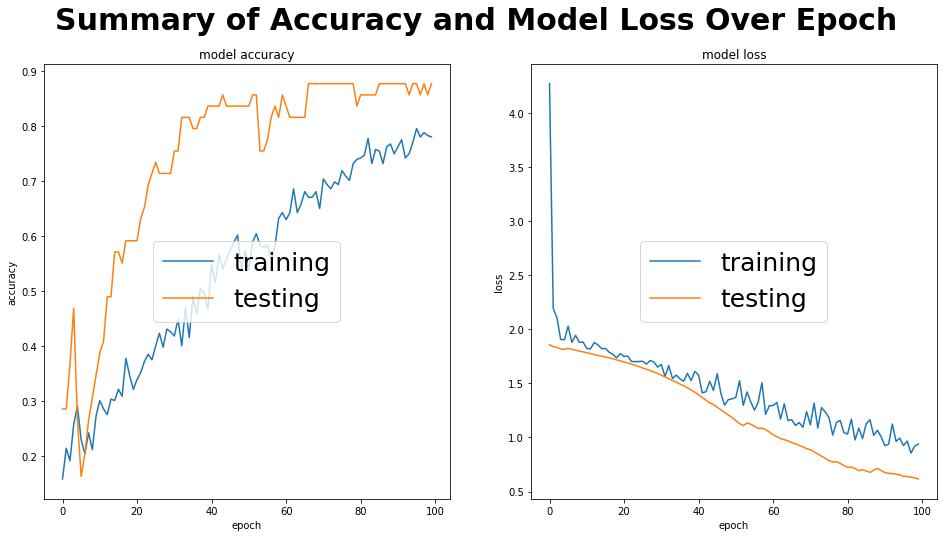

<Figure size 432x288 with 0 Axes>

In [18]:
# Print most common usual results
print('The ultimate evaluation accuracy was {:.4f}%'.format(eval_accuracy * 100))
print('The ultimate evaluation loss was {}'.format(eval_loss))

# Graph the results
plt.clf()
graph_cnt = 2

# Total Graph size and Top Title
plt.figure(figsize=(16,8))
plt.suptitle('Summary of Accuracy and Model Loss Over Epoch', fontsize=30, weight='bold')
# Build Graph Contents
training_metrics = [history.history['acc'], history.history['loss']]
validation_metrics = [history.history['val_acc'], history.history['val_loss']]
horizontal_titles = ['model accuracy', 'model loss']
vertical_axis_labels = ['accuracy', 'loss']
# Build the graph contents
for i in range(graph_cnt):
    plt.subplot(121 + (i))
    plt.plot(training_metrics[i])
    plt.plot(validation_metrics[i])
    plt.title(horizontal_titles[i])
    plt.ylabel(vertical_axis_labels[i])
    plt.xlabel('epoch')
    plt.legend(['training', 'testing'], loc='center', prop={'size': 25})

plt.show()
plt.savefig('top7_even_training_metrics.png')


In [19]:
# Instantiate the base model
vgg_features_blobs = VGGFace(include_top=False,input_shape=(img_height_req,img_width_req,img_channels_req),pooling='avg')
last_layer = vgg_features_blobs.get_layer('pool5').output
model_canned = Model(vgg_features_blobs.input, last_layer)
print("model_canned is:")
model_canned.summary()

# Instantiate the top model
model_top = Sequential()
model_top.add(Flatten(input_shape=(7,7,512)))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='relu'))
model_top.load_weights(top_model_weights_best)
print("model_top is:")
model_top.summary()

model_canned is:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [20]:
# Define a function to take an image and make a class (person_name/identity) prediction
def predict_person(img):
    image = np.copy(img)
    image = np.array(image)
    image = np.expand_dims(image, axis=0)

    # get the bottleneck prediction from the pre-trained canned_model
    bottleneck_prediction = model_canned.predict(image)
    
    # use the bottleneck prediction on the top model to get the final classification
    pred_probs = model_top.predict(bottleneck_prediction)
    pred_list = np.amax(pred_probs, axis=0).astype(np.uint8).tolist()  
    pred_idx = pred_list.index(max(pred_list))
    pred_class = person_names[pred_idx]
    return pred_class


In [21]:
# Obtain all class/person_name/identity predictions
names_preds = [predict_person(x) for x in test_X_tensors]

In [22]:
# Define a function to convert a y_test_vec (OHE-encoded y_test label) to its class
def test_y_to_name(y_test_vec):
     y_list = y_test_vec.astype(np.uint8).tolist()
     y_true_idx = y_list.index(max(y_list))
     y_class = person_names[y_true_idx]
     return y_class

In [23]:
names_ground_truth = [test_y_to_name(test_y_tensors[i]) for i in range(len(test_y_tensors))]

In [24]:
# Quantitative evaluation of the model quality on the test set
target_names = [person_names[i] for i in test_y_int]
pred_y_int = [name_index_dict[names_preds[i]] for i in range(len(test_y_int)) ]
test_err_idx = [i for i in range(len(test_y_int)) if test_y_int[i] != pred_y_int[i]]
print('test_err_idx is {}'.format(test_err_idx))
print(classification_report(test_y_int, pred_y_int, target_names=person_names))
print(confusion_matrix(test_y_int, pred_y_int, labels=range(n_classes)))

test_err_idx is [5, 19, 25, 26]
                   precision    recall  f1-score   support

    George_W_Bush       0.88      1.00      0.93         7
      Hugo_Chavez       0.70      1.00      0.82         7
Gerhard_Schroeder       1.00      0.86      0.92         7
     Colin_Powell       1.00      0.86      0.92         7
  Donald_Rumsfeld       1.00      1.00      1.00         7
     Ariel_Sharon       1.00      0.86      0.92         7
       Tony_Blair       1.00      0.86      0.92         7

      avg / total       0.94      0.92      0.92        49

[[7 0 0 0 0 0 0]
 [0 7 0 0 0 0 0]
 [1 0 6 0 0 0 0]
 [0 1 0 6 0 0 0]
 [0 0 0 0 7 0 0]
 [0 1 0 0 0 6 0]
 [0 1 0 0 0 0 6]]


# These results are actually quite good, and their not being more accurate shouldn't surprise.    With only 490 total images and 7 classes, precision, recall, and f1-score each averaging at least 90% is actually impressive.  One needs only look at the "support" colomn in the classification report above to be reminded that for each of the 7 persons only 7 images were tested for appropriate classification by the DL model.  Just 1 misclassification of an image for any of these 7 persons results in a diminution of a couple of percentage points from perfection for each such metric.